# SLR TWSA Generation

Process the SLR-DORIS hybrid TWSA product from University of Bonn's IGG

In [1]:
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import xarray as xr

import deeprec  # noqa
import deeprec.preprocessing.preprocessors as pp
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
# sns.set_style("ticks")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")

# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
# Open targets for later reference
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)

mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()

csr_grid = tgts.twsa_csr

# Apply mask
csr_grid = csr_grid.where(mask == 1)
csr_grid

<xarray.DataArray 'twsa_csr' (time: 228, lat: 360, lon: 720)> Size: 236MB
dask.array<where, shape=(228, 360, 720), dtype=float32, chunksize=(228, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 2kB 2002-04-01 2002-08-01 ... 2025-03-01
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

## Process IGG-SLR-DORIS product

In [4]:
slr = xr.open_dataset(
    ROOT_DIR / "data/raw/eval/slr_doris/boerger/IGG_SLR_DORIS_A_EWH_Land_1995-2015.nc"
)
slr


<xarray.Dataset> Size: 132MB
Dimensions:  (time: 252, longitude: 361, latitude: 181)
Dimensions without coordinates: time, longitude, latitude
Data variables:
    mjd      (time) float64 2kB ...
    lon      (longitude) float64 3kB ...
    lat      (latitude) float64 1kB ...
    ewh      (time, longitude, latitude) float64 132MB ...
Attributes:
    spatial resolution [deg]:  1
    temporal resolution:       monthly
    filter type:               DDK2

In [5]:
# Clean Data
slr = slr.rename(mjd="time", longitude="lon", latitude="lat")
# Convert from Modified Julian calendar
slr.time.attrs = {"units": "days since 1858-11-17"}
slr = xr.decode_cf(slr).assign_coords({"lat": slr.lat, "lon": slr.lon})
slr["time"] = pd.to_datetime(slr.time) + MonthBegin() - MonthBegin(normalize=True)
# Remove 360° lon (same as 0°)
slr = slr.sel(lon=slice(1, None))
# Replace 0.0 in oceans with NaNs
all_zero = (slr.ewh == 0.0).all(dim="time")
slr = slr.where(~all_zero)

# Calc baseline
baseline = slice("2004", "2009")
slr["ewh"] = slr.ewh - slr.ewh.sel(time=baseline).mean("time")
slr = slr.rename(ewh="twsa_slr_2024")
slr


<xarray.Dataset> Size: 131MB
Dimensions:        (time: 252, lon: 360, lat: 181)
Coordinates:
  * time           (time) datetime64[ns] 2kB 1995-01-01 ... 2015-12-01
  * lat            (lat) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * lon            (lon) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
Data variables:
    twsa_slr_2024  (time, lon, lat) float64 131MB nan nan nan ... nan nan nan
Attributes:
    spatial resolution [deg]:  1
    temporal resolution:       monthly
    filter type:               DDK2

In [6]:
# Resort grid indices
slr = pp.clean_grid(slr)
# Reorder dimensions
dims = ("time", "lat", "lon", ...)
slr = slr.transpose(*dims)
# Set attributes (use the one from CSR)
slr = pp.set_dim_attrs(slr)

## Save processed data

In [7]:
# Write to file
WRITE = True

ZARR_STORE = ROOT_DIR / "data/processed/igg-slr-hybrid-2.zarr"

if WRITE:
    slr.chunk(time=-1, lat=120, lon=120).astype(np.float32).to_zarr(
        ZARR_STORE, mode="w"
    )
else:
    slr = xr.open_zarr(ZARR_STORE)


## Visualization

Text(0.5, 0.98, 'TWS Anomaly, Congo Basin')

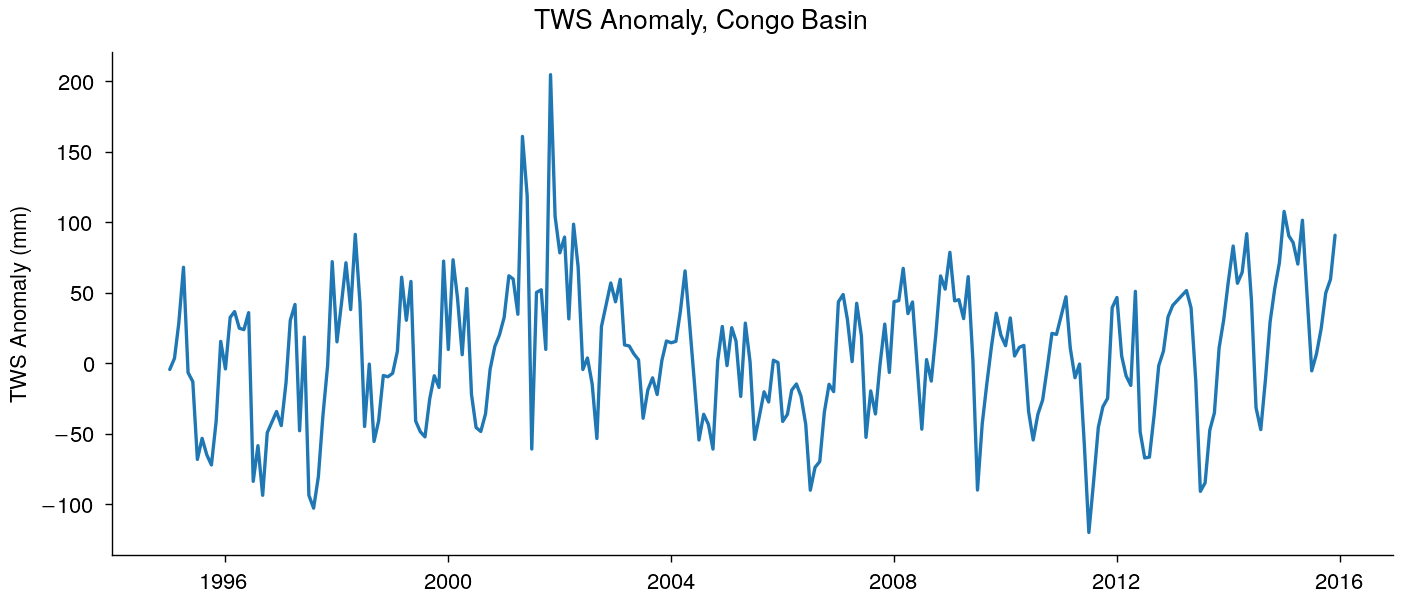

In [8]:
twsa_congo = (
    slr.twsa_slr_2024.dr.select_basins("Congo", return_region=False)
    .dr.weight_lat()
    .mean(["lat", "lon"])
)

fig, ax = plt.subplots(figsize=(7, 3))
twsa_congo.plot(ax=ax)
ax.set(ylabel="TWS Anomaly (mm)", xlabel=None)
fig.suptitle("TWS Anomaly, Congo Basin", weight="bold")


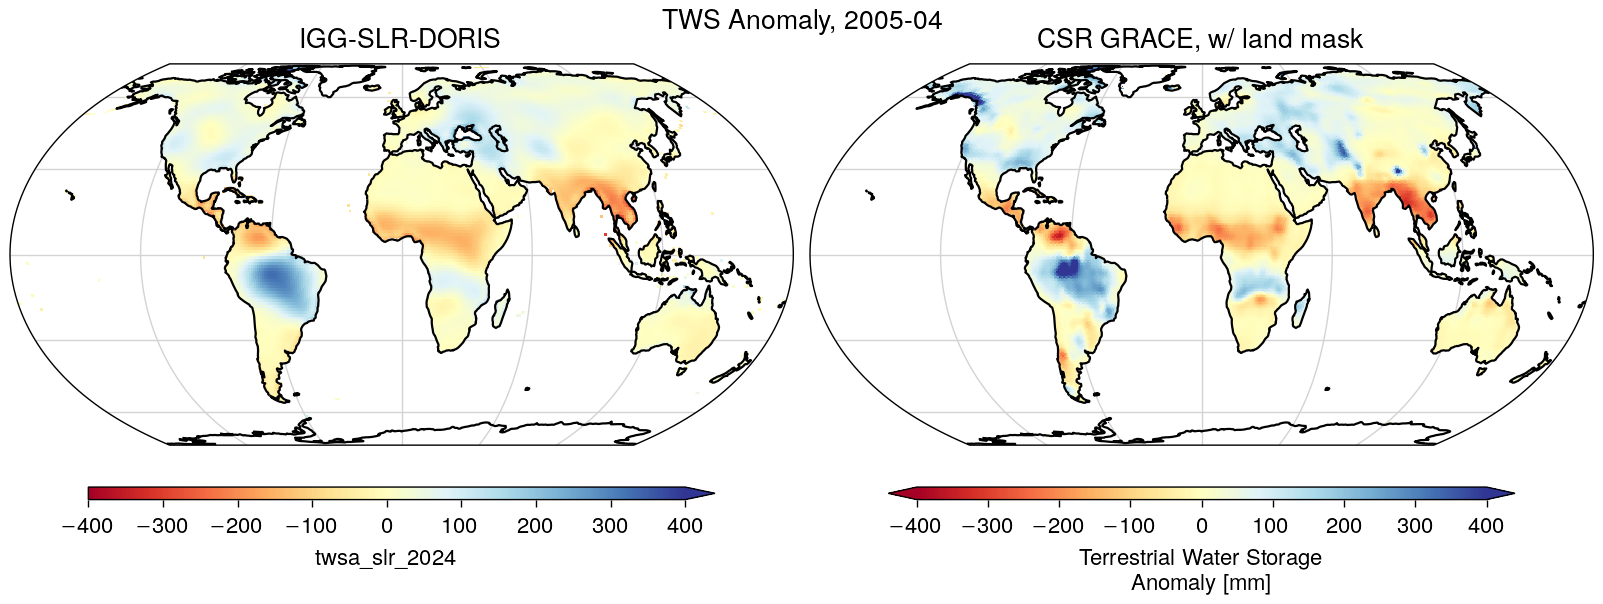

In [9]:
# Plot results
TIME = "2005-04"
plot_kwargs = dict(vmin=-400, coastlines=True, gridlines=True)

fig, axs = plt.subplots(
    ncols=2, figsize=(8, 3), subplot_kw={"projection": ccrs.EqualEarth()}
)


fig.suptitle(f"TWS Anomaly, {TIME}", weight="bold")
slr.twsa_slr_2024.sel(time=TIME).dr.projplot(ax=axs[0], **plot_kwargs)
csr_grid.sel(time=TIME).dr.projplot(ax=axs[1], **plot_kwargs)

axs[0].set_title("IGG-SLR-DORIS")
axs[1].set_title("CSR GRACE, w/ land mask");
